# Adapted from: https://github.com/sooshie/Security-Data-Analysis
# Lab 3

# Introduction
Since the previous labs have provided a (hopefully) good foundation in the various tools that will be used, this lab will explore some of the Statistics functions available for analysis. Overall this should be a gentle introduction (or reminder) about basic statistical analysis.This lab will pick up a the dataset used in Lab 1, building on your knowledge of dataframes, this lab gives the opportunity to explore what types of functions they export for data analysis.

Some goals will be how to quickly summarize data, know how to get at specific values/features of data, understand how the data looks (statistically), and how to understand the layout of the data.

# Useful Terminology
**Mean (mu)** - The average, the sum of the numbers divided by the number of numbers.

**Mode** - The number that occurs most frequently.

**Median** - The middle number when the numbers are sorted, or with an even number of numbers the average of the two middle numbers.

**Standard Deviation (sigma)** - The dispersion from the mean. The larger the standard deviation, the more spread out the numbers are.

**Variance** - How spread out the numbers are. A Variance of zero means all numbers are the same. Similar to Standard Deviation.
# Log file link
- http://www.secrepo.com/Security-Data-Analysis/Lab_1/conn.log.zip 
- https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_3/orig_ip_bytes.log.zip
___

# Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sampling generation and validation

In [4]:
input_file_path = 'data/conn.log'
total_rows = sum(1 for line in open(input_file_path))
sample_percentage = 0.01
sample_size = int(total_rows * sample_percentage)
sampled_data = pd.read_csv(input_file_path, nrows=sample_size)
outfile = 'data/conn_sample.log'
sampled_data.to_csv(outfile, index=False)

In [6]:
df = pd.read_csv(outfile, sep="\t", header=None, names=['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','service','duration','orig_bytes','resp_bytes','conn_state','local_orig','missed_bytes','history','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents','threat','sample'])
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,threat,sample
0,1.331901e+09,CCUIP21wTjqkj8ZqX5,192.168.202.79,50463,192.168.229.251,80,tcp,-,-,-,...,-,0,Fa,1,52,1,52,(empty),NaN,NaN
1,1.331901e+09,Csssjd3tX0yOTPDpng,192.168.202.79,46117,192.168.229.254,443,tcp,-,-,-,...,-,0,dDafFr,3,382,9,994,(empty),NaN,NaN
2,1.331901e+09,CHEt7z3AzG4gyCNgci,192.168.202.79,50465,192.168.229.251,80,tcp,http,0.010000,166,...,-,0,ShADfFa,4,382,3,382,(empty),NaN,NaN
3,1.331901e+09,CKnDAp2ohlvN6rpiXl,192.168.202.79,50467,192.168.229.251,80,tcp,http,0.010000,166,...,-,0,ShADfFa,4,382,3,382,(empty),NaN,NaN
4,1.331901e+09,CGUBcoXKxBE8gTNl,192.168.202.79,46119,192.168.229.254,443,tcp,ssl,0.020000,544,...,-,0,ShADadfFr,8,968,13,1744,(empty),NaN,NaN


# Once again time for data cleanup!
The cell below will, if you remember, fill all NaN valued cells with 0. The assumption here is that if Bro didn't fill in a value it's safe to set that value to zero. After that let's see what pandas determined the columns to be.

In [10]:
df = df.fillna(0)
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,threat,sample
0,1.331901e+09,CCUIP21wTjqkj8ZqX5,192.168.202.79,50463,192.168.229.251,80,tcp,-,-,-,...,-,0,Fa,1,52,1,52,(empty),0.0,0.0
1,1.331901e+09,Csssjd3tX0yOTPDpng,192.168.202.79,46117,192.168.229.254,443,tcp,-,-,-,...,-,0,dDafFr,3,382,9,994,(empty),0.0,0.0
2,1.331901e+09,CHEt7z3AzG4gyCNgci,192.168.202.79,50465,192.168.229.251,80,tcp,http,0.010000,166,...,-,0,ShADfFa,4,382,3,382,(empty),0.0,0.0
3,1.331901e+09,CKnDAp2ohlvN6rpiXl,192.168.202.79,50467,192.168.229.251,80,tcp,http,0.010000,166,...,-,0,ShADfFa,4,382,3,382,(empty),0.0,0.0
4,1.331901e+09,CGUBcoXKxBE8gTNl,192.168.202.79,46119,192.168.229.254,443,tcp,ssl,0.020000,544,...,-,0,ShADadfFr,8,968,13,1744,(empty),0.0,0.0


# More Data Cleanup

In data produced by Bro, it will often put a *-* if it can't determine a value or one wasn't seen. It's likely you saw quite a few of these in the _head()_ command above. These have a couple of different effects on the data, they can cause pandas to not recognize the column as being purely numeric and because of that it won't compute data statistics for us.


# Value substitution

The following columns need to be cleaned up this way: orig_bytes, duration, and resp_bytes.

It's important to understand the changes that you make to the underlying data by substituting values. First let's take a look at some of the differences, then make the changes to the rest of the columns.

First, make all Bro unknowns *-* into numpy unknowns *np.nan*, and see what that does.

In [22]:
df['orig_bytes'].apply(lambda x: np.nan if x == '-' else x).astype('float64').describe()

count    1.447970e+05
mean     5.035395e+01
std      1.612373e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.135377e+06
Name: orig_bytes, dtype: float64

In [23]:
df['orig_bytes'].apply(lambda x: 0 if x == '-' else x).astype('float64').describe()

count    2.269440e+05
mean     3.212731e+01
std      1.287912e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.135377e+06
Name: orig_bytes, dtype: float64

Pick one method, come up with your justification, and do the assignment for all the columns listed above. This can be done using a lambda function inside the **apply()** function. A lambda (function) is an anonymous function or one that is not bound to a specific name.

A partial sample has been provided.

In [25]:
df['orig_bytes'] = df['orig_bytes'].apply(lambda x: np.nan if x == '-' else x).astype('float64')
df['duration'] = df['duration'].apply(lambda x: np.nan if x == '-' else x).astype('float64')
df['resp_bytes'] = df['resp_bytes'].apply(lambda x: np.nan if x == '-' else x).astype('float64')
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,threat,sample
0,1.331901e+09,CCUIP21wTjqkj8ZqX5,192.168.202.79,50463,192.168.229.251,80,tcp,-,NaN,NaN,...,-,0,Fa,1,52,1,52,(empty),0.0,0.0
1,1.331901e+09,Csssjd3tX0yOTPDpng,192.168.202.79,46117,192.168.229.254,443,tcp,-,NaN,NaN,...,-,0,dDafFr,3,382,9,994,(empty),0.0,0.0
2,1.331901e+09,CHEt7z3AzG4gyCNgci,192.168.202.79,50465,192.168.229.251,80,tcp,http,0.01,166.0,...,-,0,ShADfFa,4,382,3,382,(empty),0.0,0.0
3,1.331901e+09,CKnDAp2ohlvN6rpiXl,192.168.202.79,50467,192.168.229.251,80,tcp,http,0.01,166.0,...,-,0,ShADfFa,4,382,3,382,(empty),0.0,0.0
4,1.331901e+09,CGUBcoXKxBE8gTNl,192.168.202.79,46119,192.168.229.254,443,tcp,ssl,0.02,544.0,...,-,0,ShADadfFr,8,968,13,1744,(empty),0.0,0.0


# Remove un-needed columns

The columns: 'ts', 'uid', 'proto', 'service', 'conn_state', 'local_orig', 'history', 'tunnel_parents', 'threat', 'sample' aren't needed for this lab. Let's get rid of them.

In [26]:
df.drop(['ts','uid','proto','service','conn_state','local_orig','history','tunnel_parents','threat','sample'], axis=1, inplace=True)

# Change column types

Once again, in order to do analysis, columns should be set to the correct data type.

Use the information/examples above to set orig_pkts, resp_pkts, and missed_bytes to *float64* and id.orig_p and id.resp_p to *object*

In [27]:
df['orig_pkts'] = df['orig_pkts'].apply(lambda x: np.nan if x == '-' else x).astype('float64')
df['resp_pkts'] = df['resp_pkts'].apply(lambda x: np.nan if x == '-' else x).astype('float64')
df['missed_bytes'] = df['missed_bytes'].apply(lambda x: np.nan if x == '-' else x).astype('float64')
df['id.orig_p'] = df['id.orig_p'].apply(lambda x: np.nan if x == '-' else x).astype(object)
df['id.resp_p'] = df['id.resp_p'].apply(lambda x: np.nan if x == '-' else x).astype(object)

Last but not least, The values of (empty) can creep into the data as well (it was seen in orig_ip_bytes and resp_ip_bytes), substitute these out for your chosen value above. Also, because later on we'll do some division, set all zeros to **np.nan** in the *resp_ip_bytes* column.

Make sure to verify that all your changes have held! 

*Hint: use the dtypes property*

In [28]:
df['orig_ip_bytes'] = df['orig_ip_bytes'].apply(lambda x: np.inf if x == '(empty)' else x).astype('float64')
df['resp_ip_bytes'] = df['resp_ip_bytes'].apply(lambda x: np.inf if x == '(empty)' else x).astype('float64')
df['resp_ip_bytes'] = df['resp_ip_bytes'].apply(lambda x: np.nan if x == 0 else x).astype('float64')
df.dtypes

id.orig_h         object
id.orig_p         object
id.resp_h         object
id.resp_p         object
duration         float64
orig_bytes       float64
resp_bytes       float64
missed_bytes     float64
orig_pkts        float64
orig_ip_bytes    float64
resp_pkts        float64
resp_ip_bytes    float64
dtype: object

# Feature Engineering for More Stats!

A simple exercise on how you can combine (now 2 numeric) features to create yet another numeric feature that can give you more insight into the data.

You can perform mathematical operations on columns and assign them to a new column. Run the cell below to see how it's done, and check out some of the initial values.

In [30]:
df['out_in_ratio'] = df['orig_ip_bytes']/df['resp_ip_bytes']
df['out_in_ratio'].head()

0    1.000000
1    0.384306
2    1.000000
3    1.000000
4    0.555046
Name: out_in_ratio, dtype: float64

# Statistical Summarization

As we've explored before, the **describe()** function can be used to summarize all the numerical columns in a dataframe. What happens run this is run on our our modified (and nicely cleaned up) dataframe?

Did the newly created column appear as well? Anything interesting about it?

In [32]:
df.dtypes

id.orig_h         object
id.orig_p         object
id.resp_h         object
id.resp_p         object
duration         float64
orig_bytes       float64
resp_bytes       float64
missed_bytes     float64
orig_pkts        float64
orig_ip_bytes    float64
resp_pkts        float64
resp_ip_bytes    float64
out_in_ratio     float64
dtype: object

In [33]:
df.describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,out_in_ratio
count,144797.000000,1.447970e+05,1.447970e+05,226944.0,226944.000000,2.269440e+05,226944.000000,1.698290e+05,169829.000000
mean,0.374508,5.035395e+01,2.158427e+01,0.0,1.315369,9.317813e+01,1.019256,7.831886e+01,1.101844
std,4.682021,1.612373e+04,4.481601e+03,0.0,91.731204,1.763747e+04,91.698533,9.646293e+03,0.071498
min,0.010000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000,4.000000e+01,0.000000
25%,0.010000,0.000000e+00,0.000000e+00,0.0,1.000000,4.400000e+01,0.000000,4.000000e+01,1.100000
50%,0.030000,0.000000e+00,0.000000e+00,0.0,1.000000,4.400000e+01,1.000000,4.000000e+01,1.100000
75%,0.040000,0.000000e+00,0.000000e+00,0.0,1.000000,4.400000e+01,1.000000,4.000000e+01,1.100000
max,351.960000,6.135377e+06,1.705080e+06,0.0,43697.000000,8.402145e+06,43683.000000,3.975036e+06,2.960000


There are specific functions that allow for computing the various values one at a time. 

Try computing the [Standard Deviation](https://en.wikipedia.org/wiki/Standard_deviation) of *orig_ip_bytes* using the **std()** function.

In [34]:
df.orig_ip_bytes.std()

17637.469566173455

Try computing the [Variance](https://en.wikipedia.org/wiki/Variance) of *orig_ip_bytes* using the **var()** function.

In [35]:
df.orig_ip_bytes.var()

311080332.6976949

What were the results? Why do you think that's the case?

*Hint: <a href="http://en.wikipedia.org/wiki/Standard_deviation#Basic_examples">Wikipedia</a> has a great example of how to computer the Standard Deviation, and remember the variance is just the standard deviation squared*

Below the scipy stats module can be used to compute the mode. Any surprises with the result?

In [36]:
from scipy.stats.mstats import mode
f = lambda x: mode(x, axis=None)[0]
#[value, count] returned by mode()
mode(df.orig_ip_bytes)

ModeResult(mode=array([44.]), count=array([219586.]))

# Box Plots

Also known as box whisker plots, these can be used to get a good feel for how distributed the data looks. By default the box will cover the upper and lower quartiles (eg. the 25th - 75th percentile), and a red line will be at the 50th percentile. Whiskers (lines) will extend out to show the rest of the data, with (occasionally) filler points to show outliers.

Here's how to create a simple boxplot so summarize the column that was added above.

Text(0, 0.5, 'Out-In Byte Ratio')

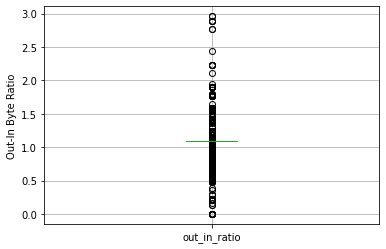

In [37]:
df.boxplot(column='out_in_ratio')
plt.ylabel('Out-In Byte Ratio')

# Slicing data

It's possible to run these functions on slices or sub-selections of the data.

Below, what happens when you run the **describe()** function on the set of numbers in *orig_ip_bytes* that are less than 200?

In [39]:
df[df.orig_ip_bytes < 200]['orig_ip_bytes'].describe()

count    222557.000000
mean         44.339540
std           4.725659
min           0.000000
25%          44.000000
50%          44.000000
75%          44.000000
max         195.000000
Name: orig_ip_bytes, dtype: float64

# Box plots on on slices

Run the **boxplot()** function on the *orig_ip_bytes* column, after selecting all of the values from *orig_ip_bytes* that are less than 200 (like above). 

How does the plot look different from the one above?

<AxesSubplot:>

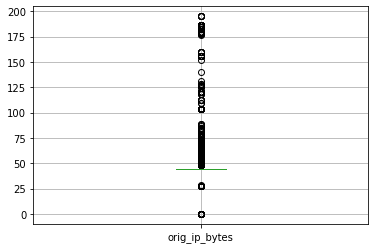

In [41]:
df[df.orig_ip_bytes < 200].boxplot(column='orig_ip_bytes')

In [42]:
# original code from: http://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html
from scipy.stats import norm,density
from numpy import linspace
from pylab import plot,show,hist,figure,title
from sklearn.preprocessing import scale

samp = scale(df.orig_ip_bytes.tolist())

param = norm.fit(samp) # distribution fitting

# now, param[0] and param[1] are the mean and 
# the standard deviation of the fitted distribution
x = linspace(min(samp),max(samp),len(samp))
# fitted distribution
pdf_fitted = norm.pdf(x,loc=param[0],scale=param[1])
# original distribution
pdf = norm.pdf(x)

title('Normal distribution vs. Bytes')
plot(x,pdf_fitted,'r-')
plot(x,pdf,'b-')
hist(samp,normed=1,alpha=.3)
show()

ImportError: cannot import name 'density' from 'scipy.stats' (C:\Users\Bromulux\anaconda3\lib\site-packages\scipy\stats\__init__.py)